# Data Pre-Processing

## Settings & User Input

In [16]:
########################################################################################################################
# Imports & Settings
########################################################################################################################

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import time
import pycountry
from pandas.core.common import flatten
from functools import reduce

In [17]:
# allow display of all rows (with scrollbar)
pd.set_option("display.max_rows", 10) #pd.set_option("display.max_rows", None)

In [18]:
########################################################################################################################
# User Input
########################################################################################################################

# source data file paths
transactions_path = '../data/external/transactions.csv'
evaluation_path = '../data/external/evaluation.csv'
items_path = '../data/external/items.csv'
subject_cats_0_path = '../data/external/subject_cats_0.csv'
gbooks_path = '../data/external/gbooks_final.json'

# pre-processed data file paths (incl. language flags)
transactions_path_pp = '../data/processed/transactions_pp.csv'
items_path_pp = '../data/processed/items_pp.csv'
header_items_path_pp = '../data/processed/header_items_pp.csv'
gbooks_volumeInfo_path_pp = '../data/processed/gbooks_volumeInfo_pp.feather'

# seaborn color palette
palette_blue = "Blues_d"
dark_blue = "#011f4b"
middle_blue = "#005b96"
light_blue = "#b3cde0"

# determine: re-calculate certain details
recompute_lg_flg = False # calculated language flags 
recompute_gbooks_volumeInfo = False # volumeInfo per book pulled from GoogleAPI

## Functions

In [19]:
########################################################################################################################
# Functions
########################################################################################################################

def clean_alt_list(list_):
#     list_ = list_.replace(', ', ',')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    return list_


def items_initial_col_processing(items_df, drop_original=True):
    # add col: get len of mt string
#     items_df['mt_len'] = items_df['main topic'].str.len()

    # add col: get first element (top level category) of mt string
#     items_df['mt_0'] = items_df['main topic'].str[0]

    # add col: main topic as set (and converted back to list)
    items_df['mt_cl'] = items_df['main topic'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))

    # adjust subtopics: set to None if subtopics list is empty
    items_df['st_cl'] = items_df['subtopics'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))
    items_df.loc[items_df['st_cl']=={''}, 'st_cl'] = None

    # add col: unique combination of main and subtopic
    items_df['mt_st_cl'] = (items_df['st_cl'] + items_df['mt_cl']) #.apply(set)
    
    # drop initial topic cols
    if drop_original:
        items_df = items_df.drop(columns=['main topic', 'subtopics'])
    
    return items_df


def tr_initial_col_processing(transactions_df):
    # add col: get click / basket / order flag
    transactions_df['click_flg'] = np.where(transactions_df['click'] > 0, 1, 0)
    transactions_df['basket_flg'] = np.where(transactions_df['basket'] > 0, 1, 0)
    transactions_df['order_flg'] = np.where(transactions_df['order'] > 0, 1, 0) 
    
    return transactions_df


def extract_gbook_volumeInfo(data, target_keys):

    # initialize final details df
    volumeInfo_df = pd.DataFrame()
    total = len(data)

    for index, row in data.iterrows():
    
        # print progress report
        if int(index%1000) == 0:
            print(f'{index}/{total}')
    
        # extract volumInfo if given
        if row["items"]:
            for item in row["items"]:

                available_keys = list(item['volumeInfo'].keys())
    #             print(f'available_keys: {available_keys}')

                extraction_keys = list(frozenset(available_keys).intersection(target_keys))
    #             print(f'extraction keys: {extraction_keys}')

                volumeInfo_item_df = pd.DataFrame(item).loc[extraction_keys,'volumeInfo']
                volumeInfo_item_df = pd.DataFrame(volumeInfo_item_df).transpose()
                volumeInfo_item_df["itemIdx"] = row["itemIdx"]
    #             display(volumeInfo_item_df)
    #             print()

                volumeInfo_df = pd.concat([volumeInfo_df,volumeInfo_item_df])

    # reset index of volumeInfo df
    volumeInfo_df.reset_index(inplace=True)
    volumeInfo_df = volumeInfo_df.drop(columns='index')  
    
    return volumeInfo_df 


def remove_special_characters(list_):
#     list_ = re.sub(r'^\W+', r'', list_) #removes leading non-alphanumerics, e.g. ",william shakespeare"

    # Remove punctuation & special characters
    list_ = re.sub(r'[®,\.!?\"\(\)\'\:#]','',list_)
    list_ = re.sub(r'-',' ',list_)
    return list_


def remove_next_sign(list_):
#     list_ = re.sub(r'^\W+', r'', list_) #removes leading non-alphanumerics, e.g. ",william shakespeare"

    # Remove punctuation & special characters
    list_ = re.sub(r'[\n]','',list_)
    
    return list_

def remove_nontitle_substrings(list_):
    list_ = str(list_)

    # type of book
    for book_type in ['taschenbuch','hardcover','hardback']:
        list_ = re.sub(f'\(.*{book_type}.*\)?','',list_) #remove all content within brackets
        list_ = re.sub(f'-\s*(\w*\s*){book_type}.*','',list_)
        list_ = re.sub(f':.*{book_type}.*','',list_)
        list_ = re.sub(f'(.*{book_type}[\w\d\s]*):','',list_)
        list_ = re.sub(f'[(special)(book)(edition)\s*]*{book_type}\s*[(special)(book)(edition)\s*]*','',list_)
        list_ = re.sub(f'{book_type}','',list_)
        
    # (light novel)
    list_ = re.sub(f'(light novel)','',list_)
    list_ = re.sub(f'\(novel\)','',list_)
    
    # (edition)
    list_ = re.sub(f'\(.*edition.*\)','',list_)  

    return list_


def convert_umlaute(list_):
    list_ = list_.replace("ä","ae").replace("ü","ue").replace("ö","oe")
    return list_


def remove_duplicate_whitespace(list_):
    list_ = re.sub(f' {2,}','',list_)
    return list_


def generate_header_set(items_df):
    """
    generates header set of items that combines attributes of several items with same title that e.g. only differ in itemID
    or other attributes
    > headerID can be used to replace itemID in transactions_df
    """
    # generate header attribute sets from sub-items -> important: generate sets to prevent duplication 
    header_items_author_df = items_df['author'].groupby([items_df.title]).apply(set).reset_index()
    header_items_publisher_df = items_df['publisher'].groupby([items_df.title]).apply(set).reset_index()
    header_items_mtst_df = items_df['mt_st_cl'].groupby([items_df.title]).apply(sum).apply(set).reset_index() # get unique list of topics

    header_items_language_df = items_df['language'].groupby([items_df.title]).apply(set).reset_index()
    header_items_number_pages_df = items_df['number_pages'].groupby([items_df.title]).apply(set).reset_index()
    header_items_recommended_age_df = items_df['recommended_age'].groupby([items_df.title]).apply(set).reset_index()
    header_items_release_date_df = items_df['release_date'].groupby([items_df.title]).apply(set).reset_index()
    header_items_description_df = items_df['description'].groupby([items_df.title]).apply(set).reset_index()
    
    # compile the list of dataframes you want to merge
    header_items_df_lst = [header_items_author_df, header_items_publisher_df, header_items_mtst_df, header_items_language_df,
                           header_items_number_pages_df,header_items_recommended_age_df, header_items_release_date_df,
                           header_items_description_df ]

    # merge all attributes
    header_items_df = reduce(lambda left,right: pd.merge(left,right,on=['title'],
                                                how='outer'), header_items_df_lst)

    # generate new header index
    header_items_df = header_items_df.reset_index().rename(columns={'index':'headerID'})

    # result inspection
    print(f'shape of header_items_df vs. items_df: {header_items_df.shape} vs. {items_df.shape}')
    print(f'cnt of duplicate "title" in header_df: {(header_items_df["title"].value_counts() > 1).sum()}')

#     print(f'\nconverted df:')
#     display(header_items_df[header_items_df['title'].isin(['(Heli-)opolis - Der verhängnisvolle Plan des Weltkoordinators',
#                                                    '13 Kings',
#                                                    'Ära der Lichtwächter'])].head(5))

#     print(f'\noriginal df:')
#     display(items_df[items_df['title'].isin(['(Heli-)opolis - Der verhängnisvolle Plan des Weltkoordinators',
#                                                    '13 Kings',
#                                                    'Ära der Lichtwächter'])].head(5))

    return header_items_df

## Data load & initial pre-processing

### DMC Source Data

In [20]:
########################################################################################################################
# Load Data
########################################################################################################################

# Load the dmc source data

# - clicks/baskets/order over a period of 3M
# - rows: one transaction for single item
transactions_df = pd.read_csv(transactions_path, delimiter='|', sep='.', encoding='utf-8')

# - list of product ids (subset of products from items_df) to be used for prediction
evaluation_df = pd.read_csv(evaluation_path, sep='.', encoding='utf-8')
items_df = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8')

# load category lookup table (manually created)
subject_cats_0 = pd.read_csv(subject_cats_0_path, delimiter=';', encoding='utf-8')

# Load pre-processed df (incl. language flags)
# items_df_pp = pd.read_csv(items_path_pp, delimiter=',', encoding='utf-8')

########################################################################################################################
# Preprocessing for further inspection
########################################################################################################################

# extract list of base cols
initial_cols= list(items_df.columns)

# add/pre-process cols
items_df = items_initial_col_processing(items_df, drop_original=True)
transactions_df = tr_initial_col_processing(transactions_df)

########################################################################################################################
# Inspection of dfs after initial pre-processing
########################################################################################################################

# show dfs after initial pre-processing
print(f'items_df after first pre-processing:')
display(items_df.head(2))

print(f'transactions_df after first pre-processing:')
display(transactions_df.head(2))

items_df after first pre-processing:


,itemID,title,author,publisher,mt_cl,st_cl,mt_st_cl
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,[YFB],[5AH],"[5AH, YFB]"
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,[AGZ],"[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ]","[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ, AGZ]"


transactions_df after first pre-processing:


,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg
0,0,21310,1,0,0,1,0,0
1,1,73018,1,0,0,1,0,0


### [DEV] Google API Extract

__To do:__
1. process remaining batches
2. reduce to one match per item
3. include details into items_df

#### Data Load & Pre-Processing

In [169]:
# Load the gbooks details (df)
gbooks_df = pd.read_json(gbooks_path, orient='records')

# reset index (to simplify later join with items_df)
if 'index' in gbooks_df.columns:
    gbooks_df = gbooks_df.drop(columns='index')
gbooks_df.reset_index(inplace=True)
gbooks_df = gbooks_df.rename(columns={'index':'itemIdx'})

# get df stats
print(f'gbooks_df:')
display(gbooks_df.head())

print(f'shape gbooks_df: {gbooks_df.shape}')
print(f'shape items_df: {items_df.shape}\n')

# inspect distribution ot total items
# plt.hist(gbooks_df['totalItems'])

ValueError: Expected object or value

In [457]:
len(gbooks_df)

78334

In [461]:
# 11.05.2021 - 09:57 - max batch index = 20k
# 11.05.2021 - 10:31 - 20k-30k
# 11.05.2021 - 10:55 - 30k-40k

batch_start_index = 40000
batch_end_index = len(gbooks_df)
volumeInfo_df = extract_gbook_volumeInfo(gbooks_df.iloc[batch_start_index+1:batch_end_index+1,:],
                                        target_keys=['title','publisher','authors','publishedDate','description','printType',
                                                       'categories','maturityRating', 'language'])
# inspect head of df
# display(volumeInfo_df.head())

# shape
print(f'shape volumeInfo_df: {volumeInfo_df.shape}\n')

# get cnt of nas
print(f'na per col: \n{volumeInfo_df.isna().sum()}\n')

# value counts specific cols
for col in ['maturityRating', 'printType','language']:
    display(pd.DataFrame(volumeInfo_df[col].value_counts()).transpose())

41000/38333
42000/38333
43000/38333
44000/38333
45000/38333
46000/38333
47000/38333
48000/38333
49000/38333
50000/38333
51000/38333
52000/38333
53000/38333
54000/38333
55000/38333
56000/38333
57000/38333
58000/38333
59000/38333
60000/38333
61000/38333
62000/38333
63000/38333
64000/38333
65000/38333
66000/38333
67000/38333
68000/38333
69000/38333
70000/38333
71000/38333
72000/38333
73000/38333
74000/38333
75000/38333
76000/38333
77000/38333
78000/38333
shape volumeInfo_df: (94825, 10)

na per col: 
description       20057
publisher         30355
maturityRating        0
title                 2
authors            3674
publishedDate      1477
language              0
categories        21522
printType            70
itemIdx               0
dtype: int64



,NOT_MATURE,MATURE
maturityRating,94225,600


,BOOK,MAGAZINE
printType,94726,29


,en,de,es,fr,it,pt,nl,sv,hu,pt-BR,...,mk,ht,ms,br,gu,fy,zu,bn,ku,eu
language,70340,11992,7927,1282,1195,473,249,229,218,97,...,1,1,1,1,1,1,1,1,1,1


In [174]:
volumeInfo_df.tail()

description  \
28089                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     “Si vous pensiez que rien ne pouvait plus égaler la série L’anneau du Sorcier, vous vous trompiez. Dans LE REVEIL DES DRAGONS, Morgan Rice nous amène la promesse d’une nouvelle série à succès en nous immergeant dans un monde fantastique peuplé de trolls et de dragons et où l’honneur, le courage, la magie et la foi en son destin sont mis en avant. Une fois de plus, Morgan nous présente des personnages forts pour lesquels nous tremblons page après page… Ce livre trouvera immédiatement sa place dans la bibliothèque des amateurs de fantastique.” --Books and Movie Reviews, Roberto Mattos Le Bestseller #1! L’auteur #1 de Bestsellers, Morgan Rice, revient avec une nouvelle série fantasy : LE REVEIL DES DRAGONS (ROIS ET SORCIERS – Livre 1). Kyra a 15 ans et rêve de devenir une grande guerrière à l’image de son père, bien qu’elle soit l’unique fille vivant dans un fort rempli d’hommes. Elle a du mal à comprendre d’où lui viennent ses aptitudes particulières, son mystérieux pouvoir et elle finit par réaliser qu’elle est différente des autres. Elle apprend qu’on lui cache un secret depuis sa naissance et qu’il existe une prophétie à son sujet. Cela l’amène à se poser des questions sur qui elle est vraiment. Lorsque Kyra atteint l’âge légal et que le seigneur local vient pour l’enlever, son père veut la marier pour la protéger. Mais Kyra refuse et décide de partir seule dans les bois dangereux où elle rencontre un dragon. Cette rencontre déclenchera une série d’événements qui changeront à jamais l’avenir du royaume. Alec a 15 ans mais n’hésite pas à se sacrifier pour son frère et à prendre sa place en tant que recrue. Il est emmené pour servir Les Flammes, un mur de feu de dizaines de mètres de haut qui protège le royaume d’une armée de Trolls vivant à l’est. De l’autre côté du royaume, Merk est un mercenaire qui s’efforce de laisser son sombre passé derrière lui. Il s’élance dans une quête au travers des bois pour devenir un Guetteur dans l’une des Tours et défendre l’Épée de feu, une source magique à l’origine du pouvoir du royaume. Mais les Trolls veulent s’emparer de cette Épée et ils préparent une invasion massive qui anéantira à jamais le royaume. Avec une atmosphère puissante et des personnages complexes, LE REVEIL DES DRAGONS est une saga impressionnante de c

In [462]:
# exclude magazines
volumeInfo_df = volumeInfo_df.loc[volumeInfo_df['printType']=='BOOK',:]
# volumeInfo_df = volumeInfo_df.drop(columns='printType') #check whether only books in subsequent batches

# reset index before saving as feather
volumeInfo_df.reset_index(inplace=True)
volumeInfo_df = volumeInfo_df.drop(columns='index')

In [465]:
# save table as feather file (for simplified later load)
gbooks_volumeInfo_path_pp = f'../data/interim/gbooks_volumeInfo_{int(batch_start_index / 1000)}k-{int(batch_end_index / 1000)}k.feather'
volumeInfo_df.to_feather(gbooks_volumeInfo_path_pp)

#### Testing 

In [136]:
test_itemIdx = 9378

display(volumeInfo_df.loc[volumeInfo_df['itemIdx']==test_itemIdx,:])
display(items_df.iloc[test_itemIdx,:])

,description,publisher,maturityRating,title,authors,publishedDate,language,categories,printType,itemIdx
26732,"The Advocate is a lesbian, gay, bisexual, tran...",NaN,NOT_MATURE,The Advocate,NaN,2004-01-20,en,NaN,MAGAZINE,9378
26733,NaN,NaN,NOT_MATURE,The Illustrated London News,NaN,1866,en,[Great Britain],BOOK,9378
26734,NaN,NaN,NOT_MATURE,The Guardian Index,NaN,1999,en,"[Guardian (Manchester, England)]",BOOK,9378
26735,NaN,NaN,NOT_MATURE,The Cultivator & Country Gentleman,NaN,1874,en,[Agriculture],BOOK,9378
26736,"Originally published in 1982, this title suppl...",Routledge,NOT_MATURE,Concordances to Conrad's Typhoon and Other Sto...,"[Todd K. Bender, Kirsten A. Bender]",2020-04-27,en,[Literary Criticism],BOOK,9378
26737,NaN,Scottish National Dictionary Association Limited,NOT_MATURE,The Compact Scottish National Dictionary,"[William Grant, David D. Murison, Scottish Nat...",1986,en,[Language Arts & Disciplines],BOOK,9378
26738,These volumes replace the 1933 Supplement to t...,NaN,NOT_MATURE,A Supplement to the Oxford English Dictionary,[R. W. Burchfield],1972,en,[English language],BOOK,9378


itemID                                                 46798
title         The Lying Game 05. Cross My Heart, Hope to Die
author                                          Sara Shepard
publisher                           Harper Collins Publ. USA
main topic                                              YFCF
                                   ...                      
mt_len                                                   4.0
mt_0                                                       Y
mt_cl                                                 [YFCF]
st_cl                                            [5AQ, YXHL]
mt_st_cl                                   [5AQ, YXHL, YFCF]
Name: 9378, Length: 11, dtype: object

## Thalia data

In [21]:
thalia_data = pd.read_pickle('../data/external/thalia_features.pkl')
print(thalia_data.head(5))

   itemID                                        description rating  \
0   21310  \nA brand-new story in the best-selling Prince...      0   
1   73018                                              \n\n       0   
2   19194  \nMare Barrow's world is divided by blood—thos...      4   
3   40250                                               \n\n      0   
4   46107  \nDie Welt der wilden Tiere\nMalen lernen war ...      0   

  number_pages  recommended_age release_date  language thalia_ranking  \
0                 7 - 9 Jahr(e)   2010-11-30  Englisch                  
1          224     ab 8 Jahr(e)   2020-12-02   Deutsch          37543   
2               13 - 17 Jahr(e)   2016-02-03  Englisch                  
3           64    3 - 6 Jahr(e)   2015-06-04   Deutsch          39540   
4           16    3 - 6 Jahr(e)   2019-02-19   Deutsch          35647   

                                           cover_url  
0  https://assets.thalia.media/img/artikel/816c5c...  
1  https://assets.thalia

In [27]:
items_df = items_df.merge(thalia_data, on='itemID')

## [DEV] Outlier Detection
- only for __transactions__: remove transactions with suspiciously high #of clicks/basket/order

In [7]:
print('Original shape:', transactions_df.shape)

Original shape: (365143, 8)


/Users/estelleweinstock/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='click'>

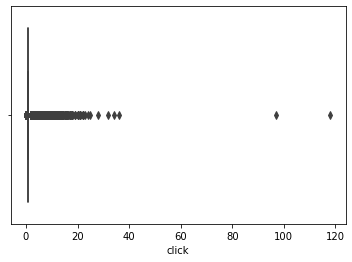

In [8]:
sns.boxplot(transactions_df['click'])

In [9]:
transactions_df = transactions_df[transactions_df['click'] < np.quantile(transactions_df.click, 0.99)]

/Users/estelleweinstock/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='basket'>

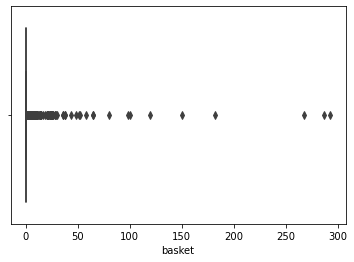

In [10]:
sns.boxplot(transactions_df['basket'])

In [11]:
transactions_df = transactions_df[transactions_df['basket'] < 2]

/Users/estelleweinstock/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='order'>

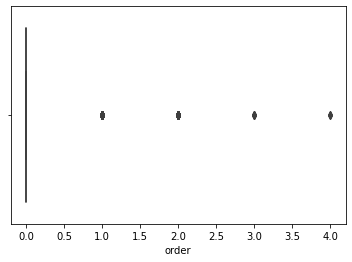

In [12]:
sns.boxplot(transactions_df['order'])

In [13]:
transactions_df = transactions_df[transactions_df['order'] < 2]

In [14]:
print('After outlier removal shape:', transactions_df.shape)

After outlier removal shape: (358086, 8)


## String normalization

__Applied:__
1. conversion to lowercase, e.g. publisher = 'TEKTIME' or 'Tektime' to 'tektime'
2. removal of leading special characters, e.g. ",william shakespeare"
3. conversion of unicode characters (ä,ö,ü)

__No fix yet:__
1. weird entries
    - author: der Authhhhor
    - diverse Autoren, Autoren
3. unicode characters like (à,é,è,°o)

# generate copy of original df for testing of pre-processing
items_df_cl = items_df.copy()
display(items_df_cl.head(5))

In [29]:
items_df_cl = items_df.copy()
display(items_df_cl.head(5))

,itemID,mt_cl,st_cl,mt_st_cl,title,author,publisher,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url
0,21310,[YFB],[5AH],"[5AH, YFB]",princess poppy the big mix up,janey louise jones,penguin random house childrens uk,\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...
1,73018,[AGZ],"[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ]","[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ, AGZ]",einfach zeichnen step by step,wiebke krabbe,schwager und steinlein,\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...
2,19194,[YFH],"[5AP, FBA]","[5AP, FBA, YFH]",red queen 1,victoria aveyard,orion publishing group,\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...
3,40250,[YB],"[YF, YBL, 5AD, YBG, 5AC]","[YF, YBL, 5AD, YBG, 5AC, YB]",meine kindergarten freunde pirat,nan,ars edition gmbh,\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...
4,46107,[WFTM],"[WD, YBL, YBLD, YBG, YBLN1, WFTM]","[WD, YBL, YBLD, YBG, YBLN1, WFTM, WFTM]",mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer,\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...


### pre-processing

In [30]:
cols_pp = ['title', 'author', 'publisher']

# convert all strings to lowercase
items_df[cols_pp] = items_df[cols_pp].applymap(lambda s:s.lower() if type(s) == str else s)

for col in cols_pp:
    
    col_cl = col + '_cl'

    # add additional col for pp titles
    items_df[col_cl] = items_df[col]

    # clean strings
    if col == 'title':
        items_df[col_cl] = items_df[col_cl].apply(remove_nontitle_substrings)
    items_df[col_cl] = items_df[col_cl].astype(str).apply(remove_special_characters)
    items_df[col_cl] = items_df[col_cl].apply(convert_umlaute)

    # reduce all spaces in the articles to single spaces
    items_df[col_cl] = items_df[col_cl].apply(remove_duplicate_whitespace)

    # print stats
    col_cnt_unique = items_df[col].nunique()
    col_cl_cnt_unique = items_df[col_cl].nunique()
    print(f'# unique {col} (before preprocessing): {col_cnt_unique} / {len(items_df)}')
    print(f'# unique {col} (after preprocessing): {col_cnt_unique} / {len(items_df)}')
    print(f'# reduction in unique {col}: {col_cnt_unique-col_cl_cnt_unique}\n')
    
# replace original cols by pre-processed cols
items_df = items_df.drop(columns=cols_pp)
items_df = items_df.rename(columns={'title_cl': 'title', 'author_cl': 'author', 'publisher_cl': 'publisher'})

# remove items with missing title after pre-processing
print(f"remove items with missing/empty title after pp: {(items_df['title']=='').sum()}")
items_df = items_df[items_df['title']!='']

# display cleaned df head
display(items_df.head(10))

# unique title (before preprocessing): 71669 / 78021
# unique title (after preprocessing): 71669 / 78021
# reduction in unique title: 0

# unique author (before preprocessing): 35655 / 78021
# unique author (after preprocessing): 35655 / 78021
# reduction in unique author: 0

# unique publisher (before preprocessing): 6896 / 78021
# unique publisher (after preprocessing): 6896 / 78021
# reduction in unique publisher: 0

remove items with missing/empty title after pp: 0


,itemID,mt_cl,st_cl,mt_st_cl,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url,title,author,publisher
0,21310,[YFB],[5AH],"[5AH, YFB]",\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...,princess poppy the big mix up,janey louise jones,penguin random house childrens uk
1,73018,[AGZ],"[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ]","[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ, AGZ]",\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...,einfach zeichnen step by step,wiebke krabbe,schwager und steinlein
2,19194,[YFH],"[5AP, FBA]","[5AP, FBA, YFH]",\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...,red queen 1,victoria aveyard,orion publishing group
3,40250,[YB],"[YF, YBL, 5AD, YBG, 5AC]","[YF, YBL, 5AD, YBG, 5AC, YB]",\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...,meine kindergarten freunde pirat,nan,ars edition gmbh
4,46107,[WFTM],"[WD, YBL, YBLD, YBG, YBLN1, WFTM]","[WD, YBL, YBLD, YBG, YBLN1, WFTM, WFTM]",\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...,mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer
5,34217,[FMR],"[FMX, 1KBB-US-NAK, 3MRBF, FRX]","[FMX, 1KBB-US-NAK, 3MRBF, FRX, FMR]",\nRhage und Mary sind Geliebte und Seelenverwa...,5,368,,2017-03-13,Deutsch,83624,https://assets.thalia.media/img/artikel/d308c5...,ewig geliebt,j r ward,heyne taschenbuch
6,31436,[YBG],"[YBG, 5AD, YBLL]","[YBG, 5AD, YBLL, YBG]",\n\n,0,40,ab 4 Jahr(e),2021-07-30,Deutsch,127158,https://assets.thalia.media/img/artikel/5ad225...,meine sticker tiere,nan,ars edition gmbh
7,14576,[YFE],"[YFH, 5AQ, YFE, FM]","[YFH, 5AQ, YFE, FM, YFE]",,,,,NaT,,,,unsterblich 01 tor der daemmerung,julie kagawa,heyne taschenbuch
8,17731,[YFH],"[YFH, 5AQ, YFE, FM]","[YFH, 5AQ, YFE, FM, YFH]","\nIn einer Welt, in der die Menschen von den V...",5,544,14 - 17 Jahr(e),NaT,Deutsch,47235,https://assets.thalia.media/img/artikel/f2e308...,unsterblich 02 tor der nacht,julie kagawa,heyne taschenbuch
9,58723,[YFB],"[5AM, 1KLSC]","[5AM, 1KLSC, YFB]",\nDer Alltag in der kolumbianischen Stadt Cart...,4,160,11 - 99 Jahr(e),1992-03-01,Deutsch,24250,https://assets.thalia.media/img/artikel/c8eb04...,pedro und die bettler von cartagena,ursula hasler,dtv verlagsgesellschaft


### validation

#### title

In [10]:
# generate titles df (with comparison column for original and cleaned title)
titles_df = pd.DataFrame(items_df_cl["title"].unique()).rename(columns={0: "title"})
titles_df['title_cl'] = titles_df['title']

# convert all strings to lowercase
titles_df = titles_df.applymap(lambda s:s.lower() if type(s) == str else s)

# clean strings
titles_df['title_cl'] = titles_df['title_cl'].astype(str).apply(remove_special_characters)
titles_df['title_cl'] = titles_df['title_cl'].apply(remove_nontitle_substrings)
titles_df['title_cl'] = titles_df['title_cl'].apply(convert_umlaute)

# reduce all spaces in the articles to single spaces
titles_df['title_cl'] = titles_df['title_cl'].apply(remove_duplicate_whitespace)

# print stats
title_cnt_unique = titles_df["title"].nunique()
title_cl_cnt_unique = titles_df["title_cl"].nunique()
print(f'# unique titles (before preprocessing): {title_cnt_unique} / {len(titles_df)}')
print(f'# unique titles (after preprocessing): {title_cl_cnt_unique} / {len(titles_df)}')
print(f'# reduction in unique titles: {title_cnt_unique-title_cl_cnt_unique}')

# display cleaned df head
display(titles_df.head(10))

# unique titles (before preprocessing): 71677 / 71677
# unique titles (after preprocessing): 71677 / 71677
# reduction in unique titles: 0


,title,title_cl
0,princess poppy the big mix up,princess poppy the big mix up
1,einfach zeichnen step by step,einfach zeichnen step by step
2,red queen 1,red queen 1
3,meine kindergarten freunde pirat,meine kindergarten freunde pirat
4,mein großes schablonen buch wilde tiere,mein großes schablonen buch wilde tiere
5,ewig geliebt,ewig geliebt
6,meine sticker tiere,meine sticker tiere
7,unsterblich 01 tor der daemmerung,unsterblich 01 tor der daemmerung
8,unsterblich 02 tor der nacht,unsterblich 02 tor der nacht
9,pedro und die bettler von cartagena,pedro und die bettler von cartagena


In [9]:
# Testing of removal    
for book in ['unsterblich 02 - tor der nacht','meine kindergarten-freunde (pferde)']:
    book = re.sub(r'-',' ',book)
    print(book)

unsterblich 02   tor der nacht
meine kindergarten freunde (pferde)


In [10]:
# print cnt of items including special terms
print(f'#items with title including:')
col = "title_cl"
for entry in ['hardcover','taschenbuch','edition','novel','hardback']:
    cnt = titles_df[col].str.contains(f'{entry}').sum()
    print(f'\t{entry}: {cnt}')

#items with title including:
	hardcover: 0
	taschenbuch: 0
	edition: 873
	novel: 324
	hardback: 0


In [ ]:
# search for specific entry
#pd.set_option("display.max_rows", None)
#pd.set_option('display.max_colwidth', None)

#search_entry = r' +'
#display(titles_df.loc[titles_df['title'].str.contains(f'{search_entry}'), :])

In [11]:
# inspect matches for specific terms/patterns
pd.set_option("display.max_rows", None)
# p = re.compile('\(.*\)')
p = re.compile(r'edition')
col = "title_cl"
matches = titles_df[col].apply(lambda s: p.findall(s))
matches = pd.DataFrame(set(flatten([x for x in matches if x])))
matches


# (1) -> elfengeist (1)
# (dt. ausgabe)
# the dark artifices box set (3 bände im schuber)
# star wars(tm) - schülerin der dunklen seite
# (sammelband) / (filmausgabe)
# (neuauflage) / (sonderausgabe)
# (roman) / (light novel)
# (großdruck)
# (gift edition) / (signed limited edition)
# (manga)
# (1-3 jahre)
# (greek edition) / (german edition) / (greek book for kids) -> additional column with language tag extracted?
# (spanish language edition of the things m -> check if error during reading in
# (hardback)

,0
0,edition


In [12]:
# cnt unique items per title
title_cnt_bpp = titles_df.groupby('title').count().reset_index().rename(columns={'title_cl': 'cnt'})
title_cnt_app = titles_df.groupby('title_cl').count().reset_index().rename(columns={'title': 'cnt'})
# display(title_cnt_bpp)
# display(title_cnt_app)

# merge both cnts to get comparison
titles_w_cnt = titles_df.merge(title_cnt_bpp, on='title', how='left')
titles_w_cnt = titles_w_cnt.merge(title_cnt_app, on='title_cl', how='left')
# display(titles_w_cnt)

# inspect differences
print(f'items with additional title matches: {len(titles_w_cnt[(titles_w_cnt["cnt_x"] < titles_w_cnt["cnt_y"])].drop_duplicates())}')

items with additional title matches: 0


In [13]:
display(titles_w_cnt[(titles_w_cnt['cnt_x'] < titles_w_cnt['cnt_y']) & 
                     (titles_w_cnt['cnt_y'] > 1)].drop_duplicates())

,title,title_cl,cnt_x,cnt_y


In [14]:
# inspect exemplary item
titles_df[titles_df['title_cl'] == 'the dungeon masters wife']
titles_df[titles_df['title_cl'] == 'z rex']

,title,title_cl
71483,z rex,z rex


#### author

In [15]:
# generate authors df (with comparison column for original and cleaned author)
author_df = pd.DataFrame(items_df_cl["author"].unique()).rename(columns={0: "author"})
author_df['author_cl'] = author_df['author']

# convert all strings to lowercase
author_df = author_df.applymap(lambda s:s.lower() if type(s) == str else s)

# clean strings
author_df['author_cl'] = author_df['author_cl'].astype(str).apply(remove_special_characters)
author_df['author_cl'] = author_df['author_cl'].apply(convert_umlaute)

# reduce all spaces in the articles to single spaces
author_df['author_cl'] = author_df['author_cl'].apply(remove_duplicate_whitespace)

# print stats
author_cnt_unique = author_df["author"].nunique()
author_cl_cnt_unique = author_df["author_cl"].nunique()
print(f'# unique authors (before preprocessing): {author_cnt_unique} / {len(author_df)}')
print(f'# unique authors (after preprocessing): {author_cl_cnt_unique} / {len(author_df)}')
print(f'# reduction in unique authors: {author_cnt_unique-author_cl_cnt_unique}')

# display cleaned df head
display(author_df.head(10))

# unique authors (before preprocessing): 35660 / 35660
# unique authors (after preprocessing): 35660 / 35660
# reduction in unique authors: 0


,author,author_cl
0,janey louise jones,janey louise jones
1,wiebke krabbe,wiebke krabbe
2,victoria aveyard,victoria aveyard
3,nan,nan
4,elizabeth golding,elizabeth golding
5,j r ward,j r ward
6,julie kagawa,julie kagawa
7,ursula hasler,ursula hasler
8,anna lummfeld,anna lummfeld
9,swen harder,swen harder


In [16]:
# cnt unique items per author
author_cnt_bpp = author_df.groupby('author').count().reset_index().rename(columns={'author_cl': 'cnt'})
author_cnt_app = author_df.groupby('author_cl').count().reset_index().rename(columns={'author': 'cnt'})
# display(author_cnt_bpp)
# display(author_cnt_app)

# merge both cnts to get comparison
authors_w_cnt = author_df.merge(author_cnt_bpp, on='author', how='left')
authors_w_cnt = authors_w_cnt.merge(author_cnt_app, on='author_cl', how='left')
# display(authors_w_cnt)

# inspect differences
print(f'items with additional author matches: {len(authors_w_cnt[(authors_w_cnt["cnt_x"] < authors_w_cnt["cnt_y"])].drop_duplicates())}')

items with additional author matches: 0


In [17]:
display(authors_w_cnt[(authors_w_cnt['cnt_x'] < authors_w_cnt['cnt_y']) & 
                     (authors_w_cnt['cnt_y'] > 1)].drop_duplicates())

,author,author_cl,cnt_x,cnt_y


In [18]:
# inspect exemplary item
author_df[author_df['author_cl'] == 'larry w miller jr']

,author,author_cl
33843,larry w miller jr,larry w miller jr


#### publisher

In [19]:
# generate publishers df (with comparison column for original and cleaned publisher)
publisher_df = pd.DataFrame(items_df_cl["publisher"].unique()).rename(columns={0: "publisher"})
publisher_df['publisher_cl'] = publisher_df['publisher']

# convert all strings to lowercase
publisher_df = publisher_df.applymap(lambda s:s.lower() if type(s) == str else s)

# clean strings
publisher_df['publisher_cl'] = publisher_df['publisher_cl'].astype(str).apply(remove_special_characters)
publisher_df['publisher_cl'] = publisher_df['publisher_cl'].apply(convert_umlaute)

# reduce all spaces in the articles to single spaces
publisher_df['publisher_cl'] = publisher_df['publisher_cl'].apply(remove_duplicate_whitespace)

# print stats
publisher_cnt_unique = publisher_df["publisher"].nunique()
publisher_cl_cnt_unique = publisher_df["publisher_cl"].nunique()
print(f'# unique publishers (before preprocessing): {publisher_cnt_unique} / {len(publisher_df)}')
print(f'# unique publishers (after preprocessing): {publisher_cl_cnt_unique} / {len(publisher_df)}')
print(f'# reduction in unique publishers: {publisher_cnt_unique-publisher_cl_cnt_unique}')

# display cleaned df head
display(publisher_df.head(10))

# unique publishers (before preprocessing): 6897 / 6897
# unique publishers (after preprocessing): 6897 / 6897
# reduction in unique publishers: 0


,publisher,publisher_cl
0,penguin random house childrens uk,penguin random house childrens uk
1,schwager und steinlein,schwager und steinlein
2,orion publishing group,orion publishing group
3,ars edition gmbh,ars edition gmbh
4,edition michael fischer,edition michael fischer
5,heyne taschenbuch,heyne taschenbuch
6,dtv verlagsgesellschaft,dtv verlagsgesellschaft
7,coppenrath f,coppenrath f
8,books on demand,books on demand
9,mantikore verlag,mantikore verlag


In [20]:
# cnt unique items per publisher
publisher_cnt_bpp = publisher_df.groupby('publisher').count().reset_index().rename(columns={'publisher_cl': 'cnt'})
publisher_cnt_app = publisher_df.groupby('publisher_cl').count().reset_index().rename(columns={'publisher': 'cnt'})
# display(publisher_cnt_bpp)
# display(publisher_cnt_app)

# merge both cnts to get comparison
publishers_w_cnt = publisher_df.merge(publisher_cnt_bpp, on='publisher', how='left')
publishers_w_cnt = publishers_w_cnt.merge(publisher_cnt_app, on='publisher_cl', how='left')
# display(publishers_w_cnt)

# inspect differences
print(f'items with additional publisher matches: {len(publishers_w_cnt[(publishers_w_cnt["cnt_x"] < publishers_w_cnt["cnt_y"])].drop_duplicates())}')

items with additional publisher matches: 0


In [21]:
display(publishers_w_cnt[(publishers_w_cnt['cnt_x'] < publishers_w_cnt['cnt_y']) & 
                     (publishers_w_cnt['cnt_y'] > 1)].drop_duplicates())

,publisher,publisher_cl,cnt_x,cnt_y


In [22]:
# inspect exemplary item
publisher_df[publisher_df['publisher_cl'] == 'digital scanning inc']

,publisher,publisher_cl
1759,digital scanning inc,digital scanning inc


## Header-Set 

__Approach:__
1. __[done]__ Generate new header-set with new IDs to unify same books that appear multiple times in the items and transactions table
    a. generate new IDs
    b. unify information
2. __[done]__ Replace the subset IDs in transactions table by superset IDs

3. Pull data on header level from external sources (e.g. google doc incl. publication date and language flag)

### generation

In [31]:
# generate header set with unique ids for "super-items"
header_items_df = generate_header_set(items_df)
header_items_df.head()

shape of header_items_df vs. items_df: (71669, 10) vs. (78021, 15)
cnt of duplicate "title" in header_df: 0


,headerID,title,author,publisher,mt_st_cl,language,number_pages,recommended_age,release_date,description
0,0,and the word became a story,{the author},{books on demand},"{FN, FM, FL}",{Englisch},{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{Italienisch},{106},{},{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a..."
2,2,leviathan wakes calibans war abaddons gate no...,{james s a corey},{orbit},"{, FLS}",{Englisch},{1792},{},{2019-11-19 00:00:00},"{\nFor the first time in hardcover, the first ..."
3,3,the ultimate vehicle colouring book for kids,{chetna },{westland publications limited},"{, YBG}",{},{104},{},{2020-08-17 00:00:00},{\n}
4,4,then he ate my boy entrancers,{louise rennison},{harpercollins publishers},"{4Z-GB-ACN, YFM, YFQ}",{Englisch},{334},{12 - 15 Jahr(e)},{2006-02-06 00:00:00},"{\nBrilliantly funny, teenage angst author Lou..."


In [18]:
## generate header set with unique ids for "super-items"
#header_items_df = generate_header_set(items_df)
#header_items_df.head()

In [32]:
# add headerID to items_df (drop before join if already existent)
if 'headerID' in items_df.columns:
    items_df = items_df.drop(columns=['headerID'])
items_df = items_df.merge(header_items_df[['title','headerID']], left_on='title', right_on='title',how='left') 
display(items_df.head())
print(f'missing headerIDs in items_df: {items_df["headerID"].isnull().sum()}')

# generate lookup table
header_items_lookup_df = items_df[['itemID','headerID']].drop_duplicates()
print(f'shape of items_df vs. header_items_lookup_df: {items_df.shape} vs. {header_items_lookup_df.shape}')

,itemID,mt_cl,st_cl,mt_st_cl,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url,title,author,publisher,headerID
0,21310,[YFB],[5AH],"[5AH, YFB]",\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...,princess poppy the big mix up,janey louise jones,penguin random house childrens uk,45065
1,73018,[AGZ],"[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ]","[YBL, YBG, WFA, YNA, 5AJ, YPA, AGZ, AGZ]",\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...,einfach zeichnen step by step,wiebke krabbe,schwager und steinlein,18678
2,19194,[YFH],"[5AP, FBA]","[5AP, FBA, YFH]",\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...,red queen 1,victoria aveyard,orion publishing group,46286
3,40250,[YB],"[YF, YBL, 5AD, YBG, 5AC]","[YF, YBL, 5AD, YBG, 5AC, YB]",\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...,meine kindergarten freunde pirat,nan,ars edition gmbh,38117
4,46107,[WFTM],"[WD, YBL, YBLD, YBG, YBLN1, WFTM]","[WD, YBL, YBLD, YBG, YBLN1, WFTM, WFTM]",\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...,mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer,37621


missing headerIDs in items_df: 0
shape of items_df vs. header_items_lookup_df: (78021, 16) vs. (78021, 2)


In [34]:
# add headerID to transactions_df (drop before join if already existent)
if 'headerID' in transactions_df.columns:
    transactions_df = transactions_df.drop(columns=['headerID'])
transactions_df = transactions_df.merge(header_items_lookup_df, left_on='itemID', right_on='itemID',how='left') 

# inspect results
display(transactions_df.head())
print(f'# missing headerIDs in transactions_df: {transactions_df["headerID"].isnull().sum()}')
print(f'# unique items in transactions_df: {transactions_df["itemID"].nunique()}')
print(f'# unique headers in transactions_df: {transactions_df["headerID"].nunique()}')

,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg,headerID
0,0,21310,1,0,0,1,0,0,45065.0
1,1,73018,1,0,0,1,0,0,18678.0
2,2,19194,1,0,0,1,0,0,46286.0
3,3,40250,1,0,0,1,0,0,38117.0
4,4,46107,1,0,0,1,0,0,37621.0


# missing headerIDs in transactions_df: 7
# unique items in transactions_df: 24909
# unique headers in transactions_df: 23455


### [DEV] merge with external data

In [89]:
# read in preprocessed data
g_data = pd.read_feather('../data/processed/gbooks_volumeInfo_pp.feather')
g_data.head(1)

,description,publisher,maturityRating,title,authors,publishedDate,language,categories,printType,itemIdx
0,A brand-new story in the best-selling Princess...,Random House,NOT_MATURE,Princess Poppy: The Big Mix Up,[Janey Louise Jones],2010-11-30,en,[Juvenile Fiction],BOOK,0


In [91]:
cols_pp = ['title', 'authors', 'publisher']

# convert all strings to lowercase
g_data[cols_pp] = g_data[cols_pp].applymap(lambda s:s.lower() if type(s) == str else s)

In [100]:
header_items_df.loc[:, 'author_'] = header_items_df.author.map(lambda x: next(iter(x)))
header_items_df.loc[:, 'publisher_'] = header_items_df.publisher.map(lambda x: next(iter(x)))
header_items_df.loc[:, 'release_date_'] = header_items_df.release_date.map(lambda x: next(iter(x)))

In [93]:
for col in cols_pp:
    
    col_cl = col + '_cl'

    # add additional col for pp titles
    g_data[col_cl] = g_data[col]

    # clean strings
    if col == 'title':
        g_data[col_cl] = g_data[col_cl].apply(remove_nontitle_substrings)
    g_data[col_cl] = g_data[col_cl].astype(str).apply(remove_special_characters)
    g_data[col_cl] = g_data[col_cl].apply(convert_umlaute)

    # reduce all spaces in the articles to single spaces
    g_data[col_cl] = g_data[col_cl].apply(remove_duplicate_whitespace)

    # print stats
    #col_cnt_unique = g_data[col].nunique()
    #col_cl_cnt_unique = g_data[col_cl].nunique()
    #print(f'# unique {col} (before preprocessing): {col_cnt_unique} / {len(items_df)}')
    #print(f'# unique {col} (after preprocessing): {col_cnt_unique} / {len(items_df)}')
    #print(f'# reduction in unique {col}: {col_cnt_unique-col_cl_cnt_unique}\n')
    
# replace original cols by pre-processed cols
g_data = g_data.drop(columns=cols_pp)
g_data = g_data.rename(columns={'title_cl': 'title', 'author_cl': 'author', 'publisher_cl': 'publisher'})

# remove items with missing title after pre-processing
print(f"remove items with missing/empty title after pp: {(g_data['title']=='').sum()}")
g_data = g_data[g_data['title']!='']

# display cleaned df head
display(g_data.head(3))

remove items with missing/empty title after pp: 0


,description,maturityRating,publishedDate,language,categories,printType,itemIdx,title,authors_cl,publisher
0,A brand-new story in the best-selling Princess...,NOT_MATURE,2010-11-30,en,[Juvenile Fiction],BOOK,0,princess poppy the big mix up,[Janey Louise Jones],random house
1,A brand-new story in the best-selling Princess...,NOT_MATURE,2010-07-28,en,[Juvenile Fiction],BOOK,0,princess poppy the fashion princess,[Janey Louise Jones],random house
2,A brand-new story in the best-selling Princess...,NOT_MATURE,2010-11-30,en,[Juvenile Fiction],BOOK,0,princess poppy the haunted holiday,[Janey Louise Jones],random house


In [145]:
#pd.merge(header_items_df, g_data[['title', 'publisher','publishedDate', 'language', 'maturityRating']], left_on=['title','release_date_'], right_on=['title', 'publishedDate'])

## Feature Engineering

### Language flag

__Idea:__
Flag Language of title in order to improve same language recommendations

__Lookup Links:__
1. [stackoverflow:](https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language) comparison of different language detection modules
2. [tds](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c) performance evaluation -> recommends __fasttext__

In [ ]:
# define test strings
str_en = "romeo and juliet: the graphic novel"
str_de = "sternenschweif. zauberhafter schulanfang"

# define whether to use existing flags and df
if not recompute_lg_flg:
    items_df = items_df_pp

#### module testing

In [ ]:
# module detector dict
lan_detector = {'ld': 'langdetect', 'gl': 'guess_language', 'lg': 'langid'}

##### langdetect (=title_ld)
[langdetect](https://pypi.org/project/langdetect/)
- important: use try-catch block to handle e.g. numerics, urls etc
- non-deterministic approach: remember to set seed for reproducible results

In [ ]:
from langdetect import DetectorFactory, detect
from langdetect.lang_detect_exception import LangDetectException

In [ ]:
# test detector on sample strings
print(detect(str_en))
print(detect(str_de))

In [ ]:
if recompute_lg_flg:
    # get start time for performance evaluation
    start_time_ld = time.time()

    # set seed for reproducability
    DetectorFactory.seed = 0

    # option 1: pre-calculate list of languages
    title_ld = []
    for title in items_df['title']:
        try:
            title_ld.append(detect(title))
    #         print(f'{title}: {detect(title)}')
        except LangDetectException:
            title_ld.append(None)
    #         print(f'{title}: "undefined"')

    # compute execution time
    end_time_ld = time.time()
    print(f'exection time langdetect: {end_time_ld - start_time_ld} seconds')

    items_df['title_ld'] = title_ld

    # option 2: use apply and title col
    # items_df['title_ld'] = items_df['title'].apply(lambda x: detect(x) if not x.isnumeric() else None)

In [ ]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_ld"].isnull().sum()}')
display(items_df[items_df["title_ld"].isnull()].head(10))

# inspect results
ld_vc = pd.DataFrame(items_df['title_ld'].value_counts().reset_index())
display(ld_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_ld', ax=ax, data=ld_vc, palette=palette_blue).set(
    xlabel='languages determined by "langdetect"',
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### guess_language (=title_gl)

- Can detect very short samples

In [41]:
from guess_language import guess_language

ModuleNotFoundError: No module named 'guess_language'

In [ ]:
print(guess_language(str_en))
print(guess_language(str_de))

In [ ]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_gl = time.time()

    # detect langauge of titles
    items_df['title_gl'] = items_df['title'].apply(lambda x: guess_language(x) if not x.isnumeric() else None)

    # set 'UNKNOWN' to None
    items_df.loc[items_df['title_gl']=='UNKNOWN','title_gl'] = None

    # compute execution time
    end_time_gl = time.time()
    print(f'exection time guess_language: {end_time_gl - start_time_gl} seconds')

In [ ]:
# inspect results
gl_vc = pd.DataFrame(items_df['title_gl'].value_counts().reset_index())
display(gl_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_gl', ax=ax, data=gl_vc, palette=palette_blue).set(
    xlabel='languages determined by "guess_language"',
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### textblob
Requires NLTK package, uses Google -> API blocked with "HTTP Error 429: Too Many Requests"

##### spacy
- [spacy doku](https://spacy.io/universe/project/spacy-langdetect): did not get it working

##### langid (=title_lg)

In [ ]:
import langid

In [ ]:
langid.classify(str_en)
langid.classify(str_de)

In [ ]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_lg = time.time()

    # option 1: pre-calculate list of languages
    title_lg = []

    for title in items_df['title']:
        title_lg.append(langid.classify(title))
        print(f'{title}: {langid.classify(title)}')

    # compute execution time
    end_time_lg = time.time()
    print(f'exection time langid: {end_time_lg - start_time_lg} seconds')

    # add col to df
    items_df['title_lg'] = [t[0] for t in title_lg]

    # option 2: use apply
    # items_df['title_lg'] = items_df['title'].apply(lambda x: TextBlob(x).detect_language() if not x.isnumeric() or  else None)

In [ ]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_lg"].isnull().sum()}')
#display(items_df[items_df["title_lg"].isnull()].head(10))

# inspect results
lg_vc = pd.DataFrame(items_df['title_lg'].value_counts().reset_index())
display(lg_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_lg', ax=ax, data=lg_vc, palette=palette_blue).set(
    xlabel='languages determined by "langid"',
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### fasttext
- official Python binding module by Facebook
- problems with installation on windows

#### module performance evaluation

In [ ]:
# compare execution time and items w/o flag
if recompute_lg_flg:
    lan_detector_eval_df = pd.DataFrame({'execution time [s]': [eval('end_time_'+det.split("_")[1]) - eval('start_time_'+det.split("_")[1]) for det in ['title_ld','title_gl','title_lg']],
                                        '#items w/o language flg':[items_df[det].isnull().sum() for det in ['title_ld','title_gl','title_lg']]},
                                       index=[det for det in lan_detector.values()])
    display(lan_detector_eval_df)

# merge results dfs
ld_gl_vc = ld_vc.merge(gl_vc, left_on='index', right_on='index', how='outer')
ld_gl_lg_vc = ld_gl_vc.merge(lg_vc, left_on='index', right_on='index', how='outer')
display(ld_gl_lg_vc.transpose())
ld_gl_lg_vc = ld_gl_lg_vc.head(10)

# rename columns
ld_gl_lg_vc.columns = ['index', 'langdetect','guess_language','langid']

# add language name
ld_gl_lg_vc['language_name'] = ld_gl_lg_vc['index'].apply(lambda l: pycountry.countries.get(alpha_2=l).name if l != 'en' else 'English')

# transform model cols into identifier column for plotting
ld_gl_lg_vc = pd.melt(ld_gl_lg_vc, id_vars=["index", "language_name"],
                  var_name="flag_m", value_name="idCnt")
#display(ld_gl_lg_vc)

# Draw a nested barplot by language detector
sns.set_theme()
fig, ax = plt.subplots(figsize=(5,4))
g = sns.barplot(y="language_name", x="idCnt", hue="flag_m", data=ld_gl_lg_vc, palette=palette_blue, orient='h')
g.set(xlabel="# itemID", ylabel = "")
g.legend(loc='lower right')
plt.show()

### [DEV] Topic Similarity


In [11]:
# creation of sentence embeddings for each category

import pandas as pd
from gensim.models import KeyedVectors

# load embeddings
model = KeyedVectors.load_word2vec_format('../tempData/fetchedData/fasttext.wiki.en.300.vocab_200K.vec')
df = pd.read_json('../tempData/processedData/categories_translated.json', typ='series')

# create cat strings
def cats(row):
    words = ''
    cat_ins = ''
    for char in row:
        cat_ins = cat_ins + char
        try:
            words = words + df.loc[cat_ins].lower() +' '
        except:
            pass
    return words

# calculate averaged sentence embedding
def calc(words):
    summ = 0
    i = 0
    for word in set(words.split()):
        try:
            summ = summ + model[word]
            i = i+1
        except:
            pass
    return summ/i

In [12]:
# loop trough all cats & save as list to be able to save in df
avgs = []
for i in df.index:
    avgs.append([calc(cats(i))])

In [13]:
embs = pd.DataFrame(avgs, index=df.index, columns=['fasttext_emb'])
embs.head(2)

,fasttext_emb
1,"[-0.1892, -0.030574098, -0.010315008, 0.181903..."
1A,"[-0.23420997, -0.053331066, -0.009325569, 0.17..."


In [14]:
def f(col):
    s=0
    try:
        for e in col:
            s = s + embs.loc[e][0]
        return s / len(col)
    except KeyError:
        return 0

In [35]:
# create list from set
header_items_df.loc[:, 'mt_st_'] = header_items_df.mt_st_cl.map(lambda x: list(x))

In [36]:
header_items_df.mt_st_ = header_items_df.mt_st_.map(lambda x: ' '.join(x).split())

In [37]:
header_items_df.drop('mt_st_cl', axis=1, inplace=True)

In [38]:
# add categorical embeddings
header_items_df['emb_cats'] = header_items_df.apply(lambda x: f(x['mt_st_']), axis=1)

## Descriptions

In [39]:
header_items_df.loc[:, 'description_'] = header_items_df.description.map(lambda x: next(iter(x)))

In [40]:
# Preprocessing
# convert all strings to lowercase
header_items_df['description_'] = header_items_df['description_'].apply(lambda s:s.lower() if type(s) == str else s)    
header_items_df['description_'] = header_items_df['description_'].apply(remove_nontitle_substrings)
header_items_df['description_'] = header_items_df['description_'].astype(str).apply(remove_special_characters)
header_items_df['description_'] = header_items_df['description_'].apply(convert_umlaute)
header_items_df['description_'] = header_items_df['description_'].apply(remove_next_sign)
# reduce all spaces in the articles to single spaces
header_items_df['description_'] = header_items_df['description_'].apply(remove_duplicate_whitespace)
# display cleaned df head
display(header_items_df.head(1))

,headerID,title,author,publisher,language,number_pages,recommended_age,release_date,description,mt_st_,emb_cats,description_
0,0,and the word became a story,{the author},{books on demand},{Englisch},{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,"[FN, FM, FL]","[0.015625147, -0.051195245, -0.09722235, 0.295...",at the beginning was the wordand from the word...


In [41]:
header_items_df.drop('description', axis=1, inplace=True)

In [43]:
from googletrans import Translator
translator = Translator()

In [55]:
# header_items_df[header_items_df['language'] == {'Italienisch'}]['description_'].apply(translator.translate,src='it',  dest='en' ).apply(getattr, args=('text',))

1        amicizia scuola amore alti e bassi in and out ...
6        il genere umano e destinato a scomparirequesto...
214                                                       
217                                                       
411      sette storie sempre più in là nel tempo compon...
                               ...                        
69990    willie è un giovane ippopotamo birbantello che...
71150    nella regione di dehugia koban un umile pastor...
71473                                                     
71476                                                     
71536    zuppa di mitocondri contiene 16 racconti brevi...
Name: description_, Length: 847, dtype: object

In [56]:
# header_items_df['descriptions_trans'] = header_items_df['description_'].apply(translator.translate, dest='en' ).apply(getattr, args=('text',))

### Recommended age

##### bin into children/ teenagers / adults
##### fill empty values with adults

In [57]:
# get rid of set structure (only get one value)
header_items_df.loc[:, 'recommended_age'] = header_items_df.recommended_age.map(lambda x: next(iter(x)))

In [71]:
header_items_df['rec_age'] = header_items_df.recommended_age.str.findall('\d+')

### Language Tag

In [76]:
# create new lang tag (only get one value) but keep set

header_items_df.loc[:, 'lang'] = header_items_df.language.map(lambda x: next(iter(x)))

## Export of final pre-processed dfs

In [87]:
# export transactions_df
transactions_df.to_csv(transactions_path_pp)

In [88]:
transactions_df.to_csv('transactions_wo.csv')

In [68]:
header_items_df.to_csv('header_items_df.csv')

In [70]:
items_df[]

,itemID,mt_cl,st_cl,mt_st_cl,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url,title,author,publisher,headerID
0,21310,[YFB],[5AH],"[5AH, YFB]",\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...,princess poppy the big mix up,janey louise jones,penguin random house childrens uk,45065
1,73018,[AGZ],"[YNA, YBL, YPA, 5AJ, YBG, AGZ, WFA]","[YNA, YBL, YPA, 5AJ, YBG, AGZ, WFA, AGZ]",\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...,einfach zeichnen step by step,wiebke krabbe,schwager und steinlein,18678
2,19194,[YFH],"[FBA, 5AP]","[FBA, 5AP, YFH]",\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...,red queen 1,victoria aveyard,orion publishing group,46286
3,40250,[YB],"[YF, YBL, 5AD, 5AC, YBG]","[YF, YBL, 5AD, 5AC, YBG, YB]",\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...,meine kindergarten freunde pirat,nan,ars edition gmbh,38117
4,46107,[WFTM],"[YBL, WFTM, YBLN1, YBLD, YBG, WD]","[YBL, WFTM, YBLN1, YBLD, YBG, WD, WFTM]",\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...,mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer,37621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78016,37678,[YFA],[YFJ],"[YFJ, YFA]",\n,0,32,4 - 8 Jahr(e),2016-01-15,,,https://assets.thalia.media/img/artikel/78ac71...,timeless fairy tales,brothers grimm marie catherine baroness daulnoy,mediamorphosis,65307
78017,68688,[FMB],[],"[, FMB]",\n,0,,,2020-05-23,Deutsch,,https://assets.thalia.media/img/artikel/114bf3...,demon games,a witt timothy a witt,iuniverse,12921
78018,57291,[YFU],[],"[, YFU]",\n,0,88,,2010-01-15,Englisch,,https://assets.thalia.media/img/artikel/87060a...,lori and the lions den,a m glass,xlibris,34895
78019,78130,[YFC],"[YFG, YFH]","[YFG, YFH, YFC]",,,,,NaT,,,,the everywhere armchair,ersila bee,eloquent books,56943


In [69]:
header_items_df

,headerID,title,author,publisher,language,number_pages,recommended_age,release_date,mt_st_,description_
0,0,and the word became a story,{the author},{books on demand},{Englisch},{304},{},{2018-04-17 00:00:00},"[FM, FN, FL]",at the beginning was the wordand from the word...
1,1,evvai,{cristina polacchini},{lulucom},{Italienisch},{106},{},{2015-08-01 00:00:00},[YFB],amicizia scuola amore alti e bassi in and out ...
2,2,leviathan wakes calibans war abaddons gate no...,{james s a corey},{orbit},{Englisch},{1792},{},{2019-11-19 00:00:00},[FLS],for the first tim the first three novels in co...
3,3,the ultimate vehicle colouring book for kids,{chetna },{westland publications limited},{},{104},{},{2020-08-17 00:00:00},[YBG],
4,4,then he ate my boy entrancers,{louise rennison},{harpercollins publishers},{Englisch},{334},{12 - 15 Jahr(e)},{2006-02-06 00:00:00},"[YFQ, 4Z-GB-ACN, YFM]",brilliantly funny teenage angst author louise ...
...,...,...,...,...,...,...,...,...,...,...
71664,71664,órbitas míticas volume i,{kerry nietz},{bear publications},{Portugiesisch},{266},{},{2020-05-30 00:00:00},"[FM, DNT]",quatorze das melhores histórias de ficção espe...
71665,71665,óscar el oso pardo aprende a ser agradecido,{misty black},{berry patch press llc},{Spanisch},{36},{},{2020-11-05 00:00:00},"[YNMD, YFB, 5HCS]",¡la gratitud nos ayuda a ser felices aún cuand...
71666,71666,ô yrdann 1,{hadrien sins},{books on demand},{Französisch},{332},{ab 12 Jahr(e)},{2020-05-23 00:00:00},"[FLS, FM, 5AX]",un cadeau des confins de lespace vient perturb...
71667,71667,øen læge moreau the island of dr moreau danish...,{herbert george wells},{adizes inst},{Dänisch},{140},{},{2019-06-08 00:00:00},[FL],en skibbrudte herre strandet på en stillehavsø...
